###  Install and import feedback gadget


In [1]:
# @title Project Background

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

from IPython.display import Image, display
import os
from pathlib import Path

In [2]:
# @markdown Local installation

import contextlib
import io
import os

In [3]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
import logging


# comment the next three lines if you want to see all training logs
pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
for pl_log in pl_loggers:
    logging.getLogger(pl_log.name).setLevel(logging.WARNING)

random.seed(2024)

dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
if HOME_DIR is None:
    HOME_DIR = ""
print(HOME_DIR)

ComputationThruDynamicsBenchmark/


In [4]:
import torch
device = torch.device("mps")

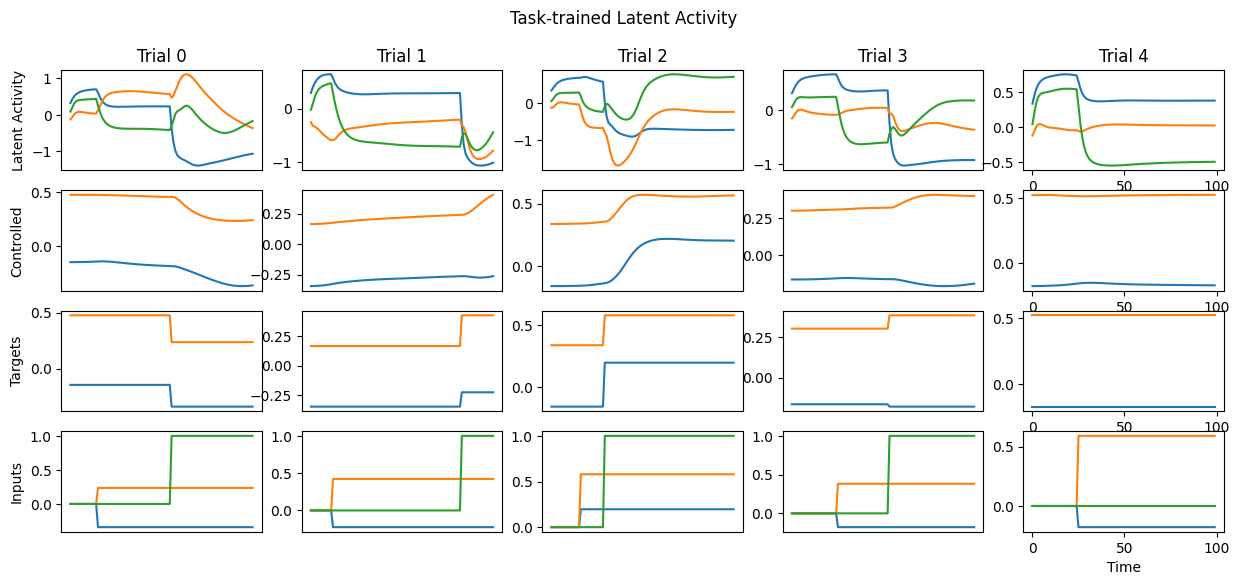

In [6]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_GRU_128 = HOME_DIR + "models_RT_GRU_128/"
# Create the analysis object:
analysis_GRU_128 = TT_RandomTarget(
    run_name = "GRU_128_RT",
    filepath = fpath_GRU_128)

analysis_GRU_128.plot_trial_io(num_trials = 5)

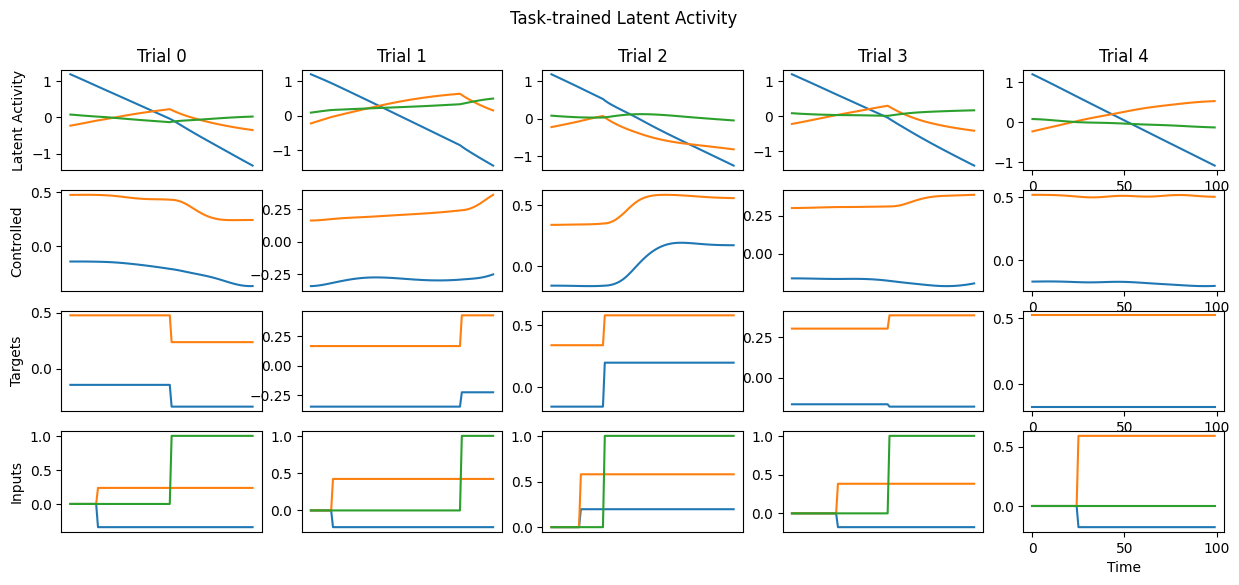

In [8]:
fpath_NODE = HOME_DIR + "models_RT_NODE_3/"
# Create the analysis object:
analysis_NODE = TT_RandomTarget(
    run_name = "NODE_3_RT",
    filepath = fpath_NODE)

analysis_NODE.plot_trial_io(num_trials = 5)

### Checking Affine Transform

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_GRU_128
target = analysis_NODE

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape}"
      f"\nLatent shape for target model: {latents_targ.shape}")

Latent shape for source model: (800, 100, 128)
Latent shape for target model: (800, 100, 32)


### Checking PCA


In [10]:
# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

R2 of linear regression fit: [0.8427351  0.9099076  0.82335496 0.87435627 0.6075235  0.68185186
 0.7389512  0.75143445 0.70206034 0.5226852  0.65229976 0.6451189
 0.62511873 0.43030542 0.5346262  0.4422891  0.36522615 0.4084859
 0.43091667 0.41949987 0.2888289  0.31472826 0.24399704 0.23103106
 0.29694957 0.26184058 0.30554628 0.24046135 0.24341226 0.23101938
 0.2678001  0.18815935]
Variance-weighted R2 of linear regression fit: 0.8451516032218933


array([0.36181954, 0.23690103, 0.14403035, 0.10428658, 0.05625831,
       0.02908692, 0.01492349, 0.00952354, 0.00686038, 0.00538731],
      dtype=float32)

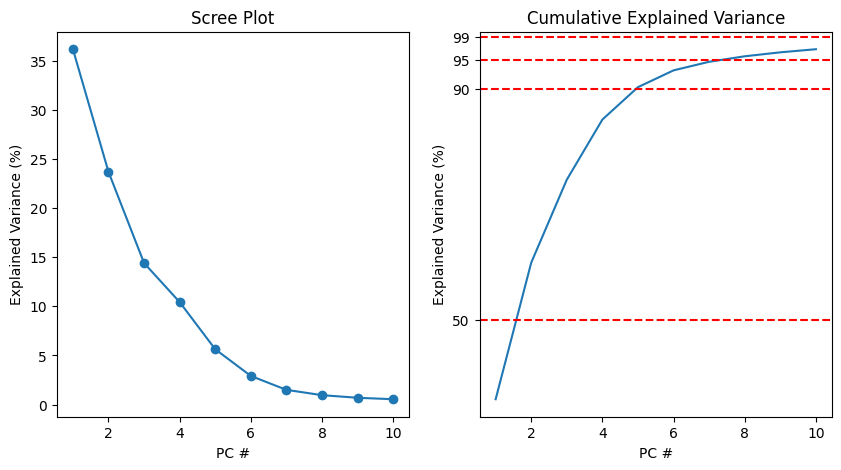

In [11]:
analysis_GRU_128.plot_scree()

array([0.7503384 , 0.14170979, 0.06124982, 0.0158659 , 0.00887754,
       0.0051723 , 0.00437889, 0.00297666, 0.00248997, 0.00200044],
      dtype=float32)

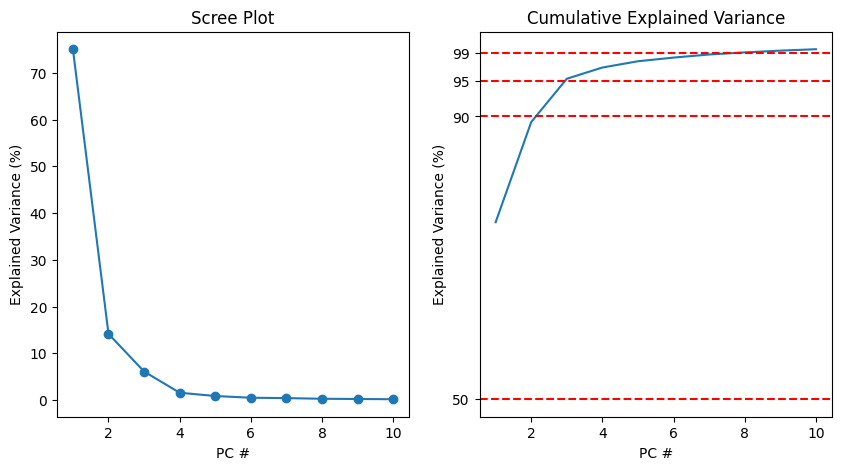

In [12]:
analysis_NODE.plot_scree()

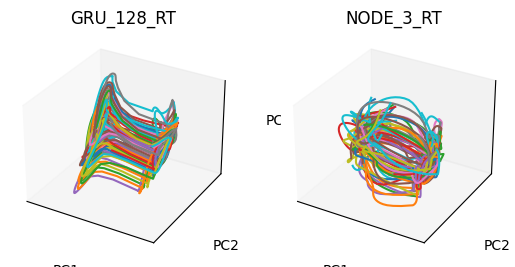

In [13]:
from ctd.comparison.comparison import Comparison
comp = Comparison()
comp.load_analysis(analysis_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_NODE)
comp.plot_trials_3d_reference(num_trials=100)

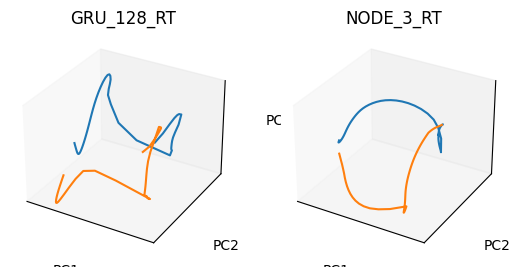

In [14]:
from ctd.comparison.comparison import Comparison
comp = Comparison()
comp.load_analysis(analysis_GRU_128, reference_analysis=True)
comp.load_analysis(analysis_NODE)
comp.plot_trials_3d_reference(num_trials=2)

## Fixed point finding

In [34]:
print('Hello world')

Hello world


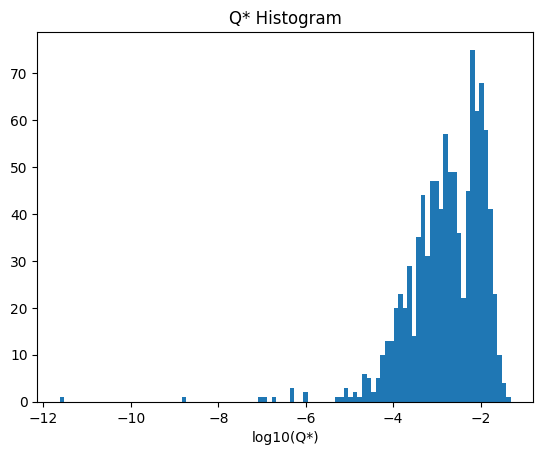

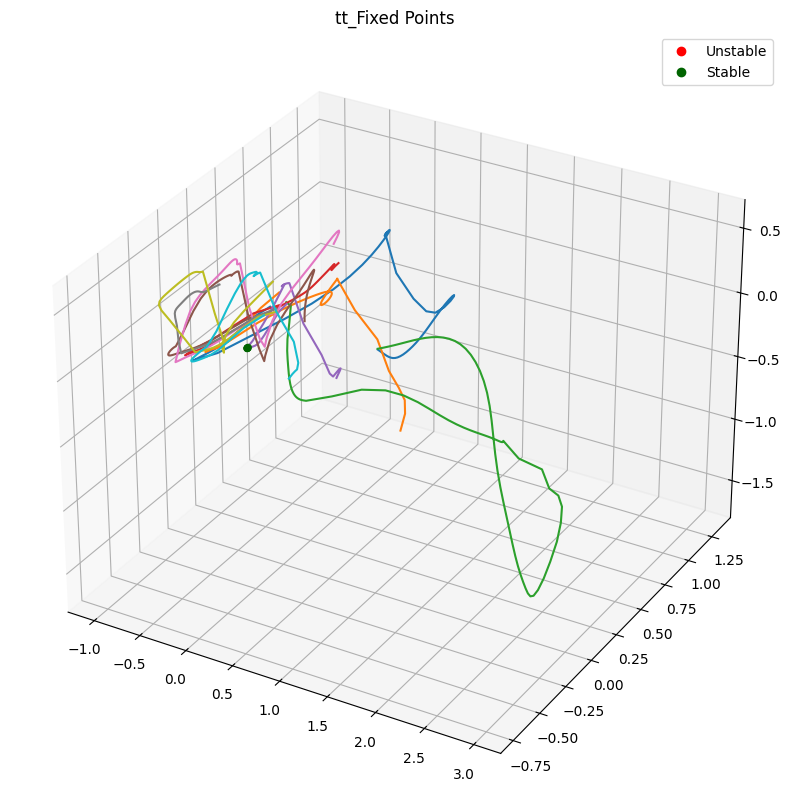

In [51]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_gru = analysis_GRU_128.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-6,
        noise_scale=0.0,
        max_iters=200000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-6,
    )

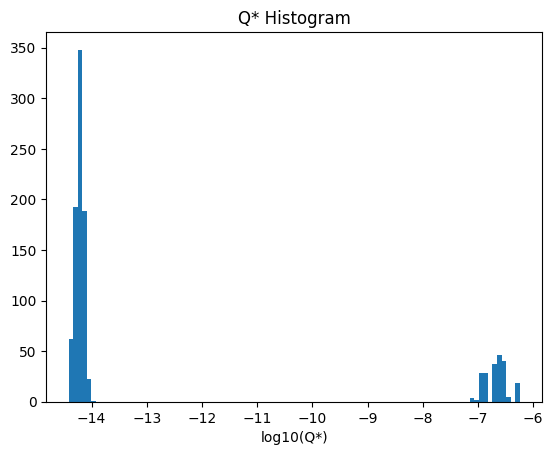

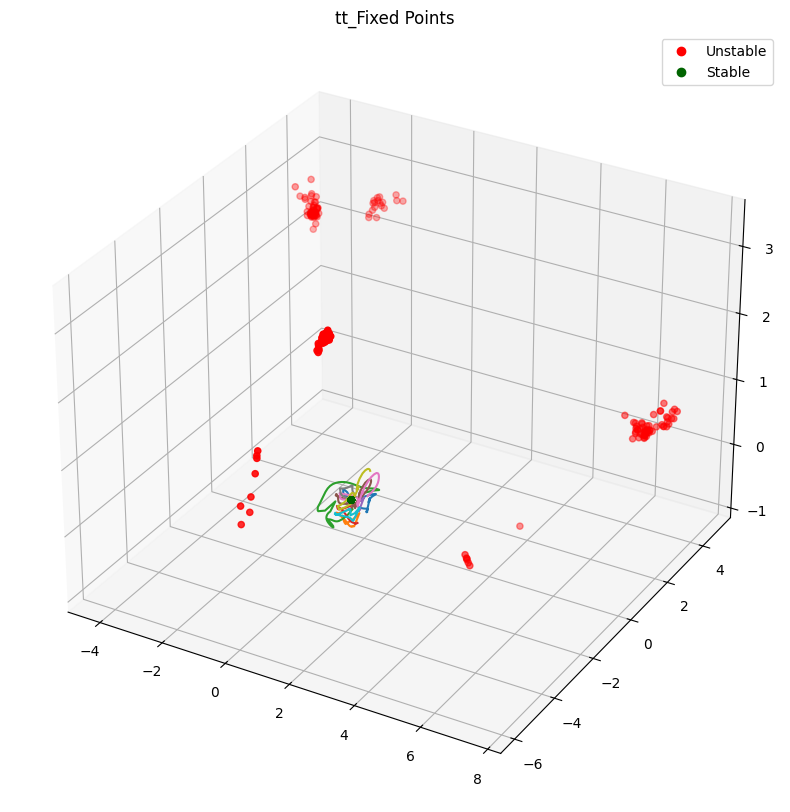

In [57]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_gru = analysis_GRU_128.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-4,
        noise_scale=0.1,
        max_iters=200000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-6,
    )

/var/folders/9b/swmkwk292kv02szf2vpn3dww0000gn/T/ipykernel_10284/1880019302.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


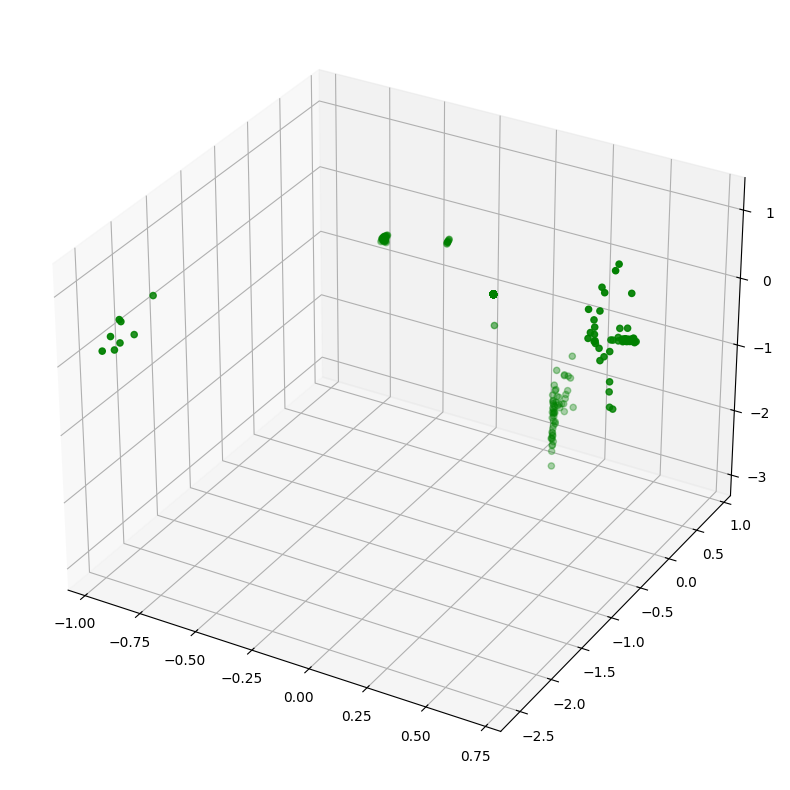

In [58]:
import matplotlib.pyplot as plt
q_thesh = 1e-6
q_vals = fps_gru.qstar
x_star = fps_gru.xstar[q_vals < q_thesh]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_star[:, 0], x_star[:, 1], x_star[:, 2], c='g', marker='o')
fig.show()


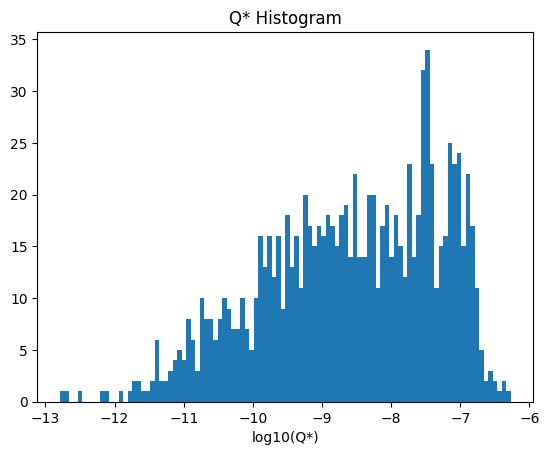

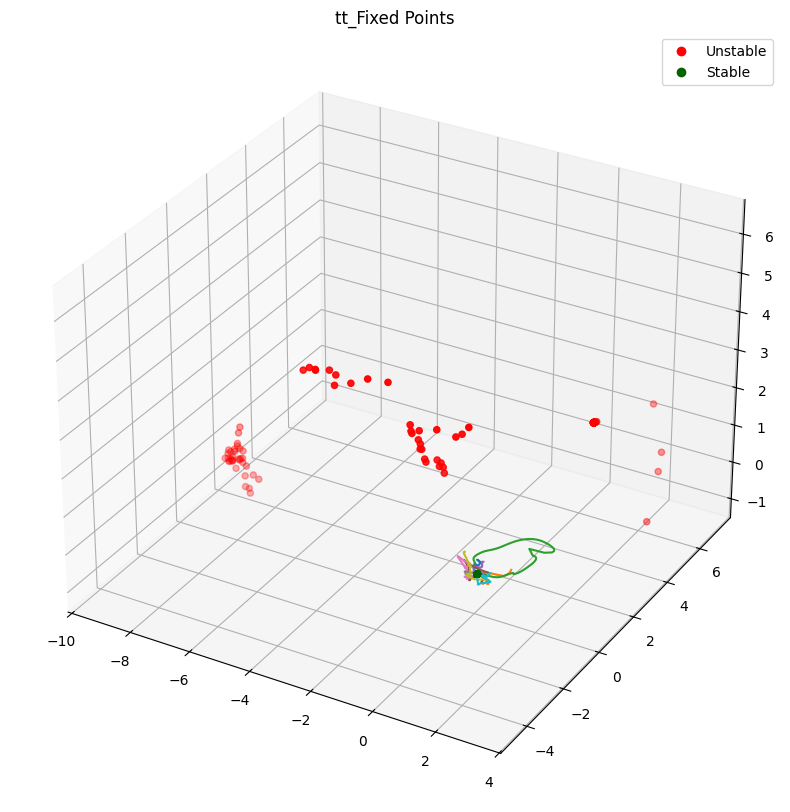

In [55]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_gru = analysis_GRU_128.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-3,
        noise_scale=0.0,
        max_iters=200000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-6,
    )

/var/folders/9b/swmkwk292kv02szf2vpn3dww0000gn/T/ipykernel_10284/1880019302.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


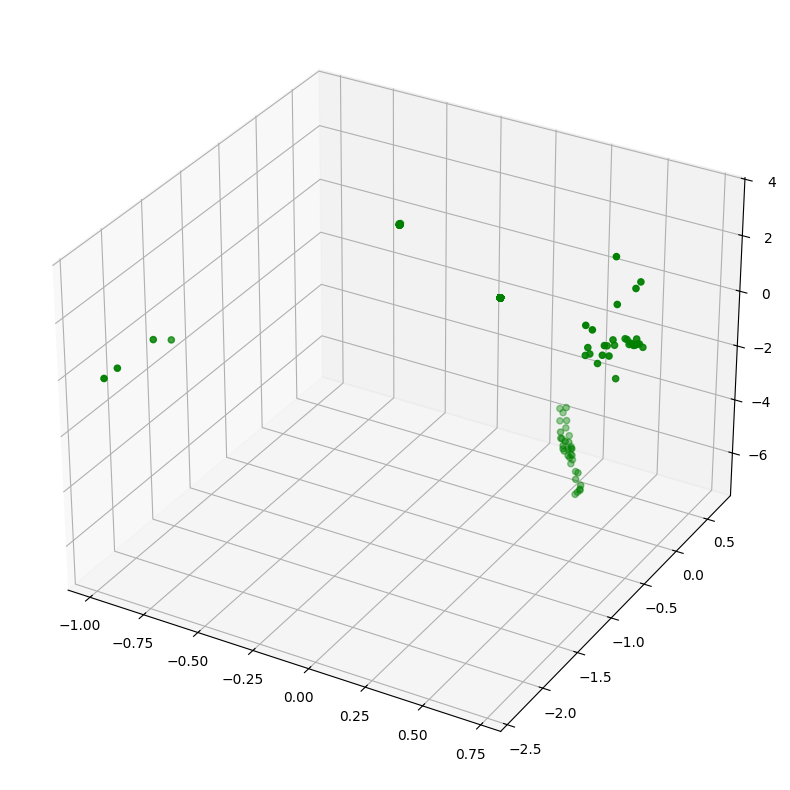

In [56]:
import matplotlib.pyplot as plt
q_thesh = 1e-6
q_vals = fps_gru.qstar
x_star = fps_gru.xstar[q_vals < q_thesh]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_star[:, 0], x_star[:, 1], x_star[:, 2], c='g', marker='o')
fig.show()


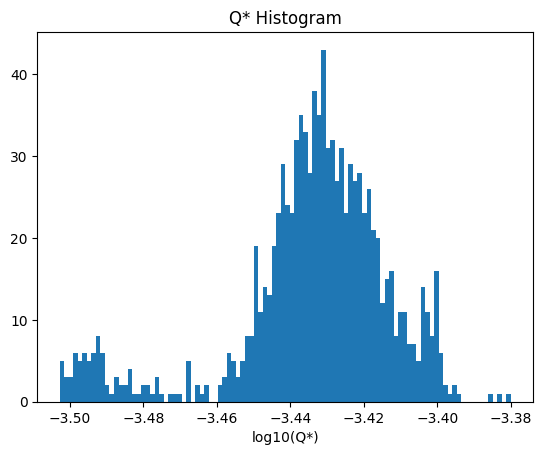

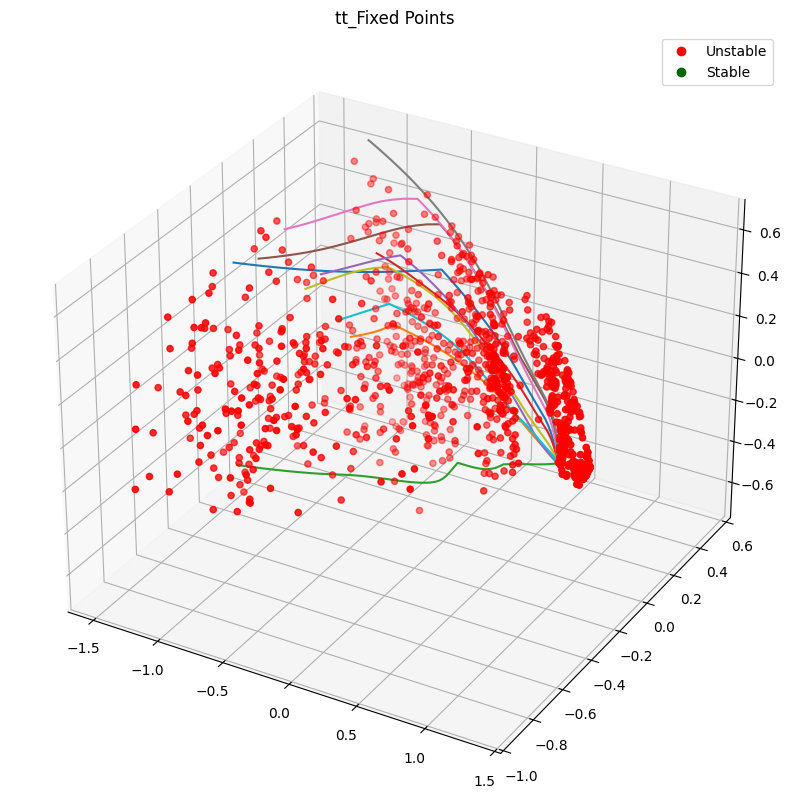

In [53]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps_node = analysis_NODE.plot_fps(
        inputs= torch.zeros(17),
        n_inits=1024,
        learning_rate=1e-7,
        noise_scale=0.0,
        max_iters=2000000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-2,
    )

/var/folders/9b/swmkwk292kv02szf2vpn3dww0000gn/T/ipykernel_10284/556689575.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


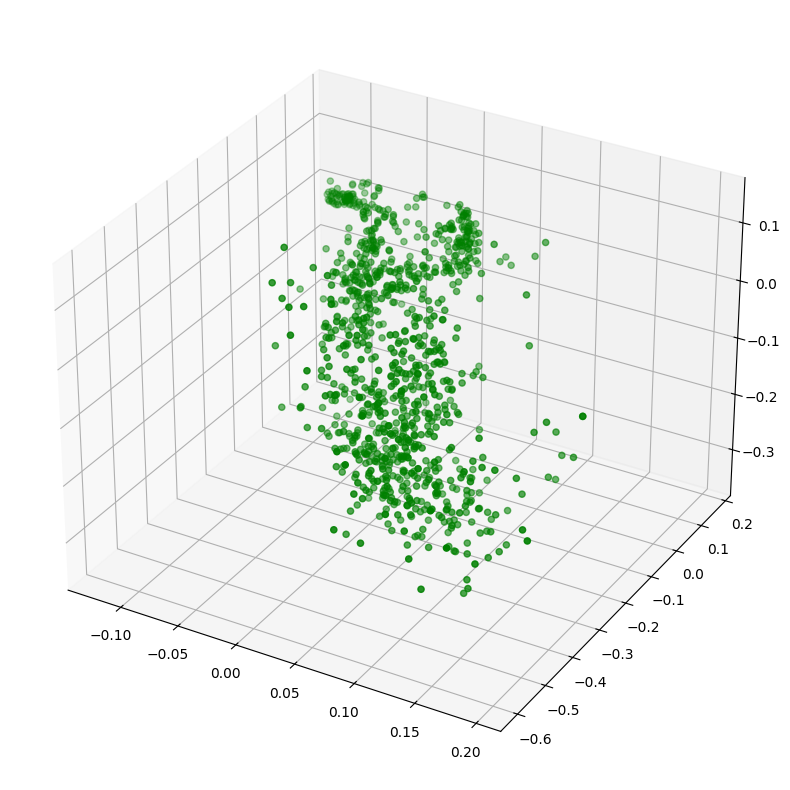

In [54]:
import matplotlib.pyplot as plt
q_thresh = 1e-2
q_vals = fps_node.qstar
x_star = fps_node.xstar[q_vals < q_thresh]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_star[:, 0], x_star[:, 1], x_star[:, 2], c='g', marker='o')
fig.show()


In [ ]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_GRU_128 = HOME_DIR + "models_RT_GRU_128/"
# Create the analysis object:

analysis_GRU_128 = TT_RandomTarget(
    run_name = "RT_GRU_128",
    filepath = fpath_GRU_128)

analysis_GRU_128.plot_trial(1)

analysis_GRU_128.plot_trial(99)

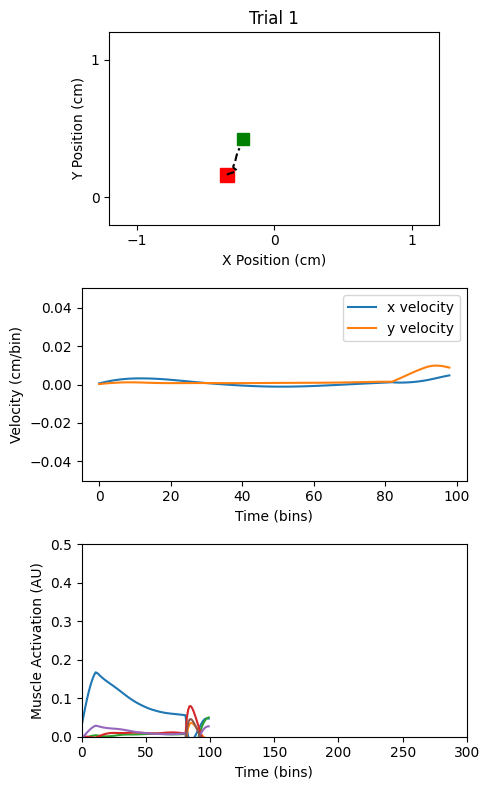

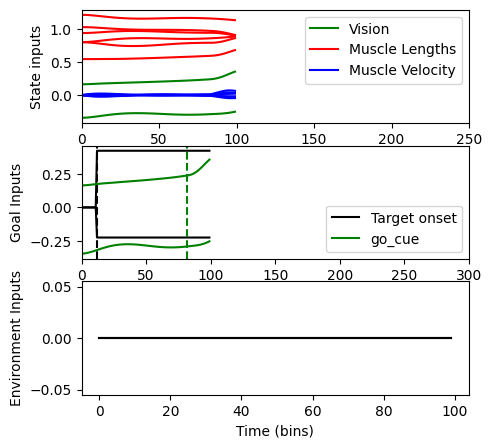

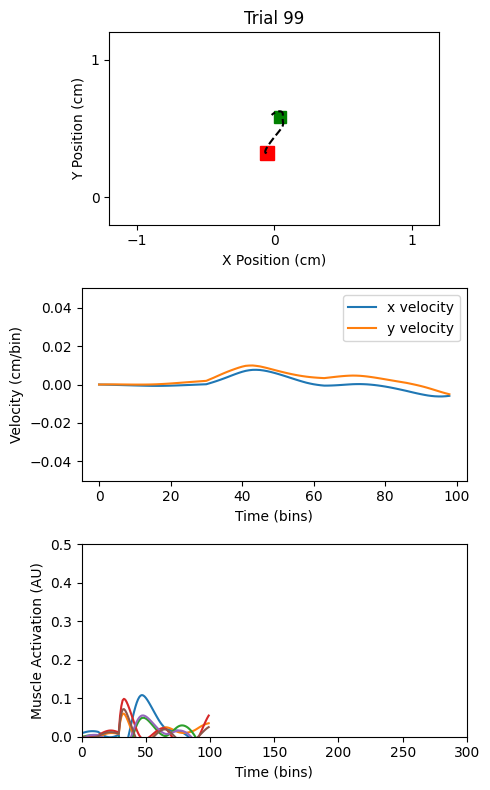

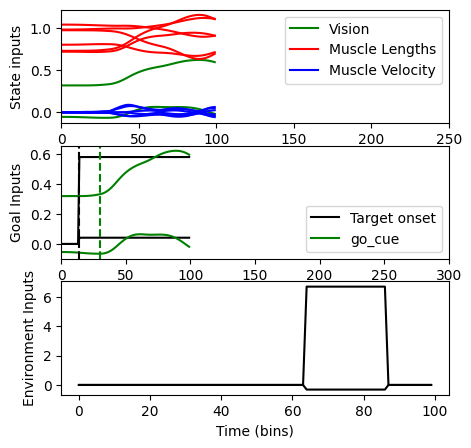

In [20]:
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget

fpath_NODE = HOME_DIR + "models_RT_NODE_3/"
# Create the analysis object:

analysis_NODE = TT_RandomTarget(
    run_name = "RT_NODE",
    filepath = fpath_NODE)

analysis_NODE.plot_trial(1)

analysis_NODE.plot_trial(99)

### Try using the coupled fixed point

Importantly, this task is distinct from the previous two tasks because the outputs of the model affect the subsequent inputs!

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/MotorNetIllustration-01.png?raw=true" width="400"/>


Visualizing the latent dynamics of models trained on MotorNet tasks, we can see that there are complex features in the state space, but we'll leave that to you to figure out what they mean!

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/MotorNetGif.gif?raw=true" width="300"/>

In the later questions, we will ask you to modify the environments in MotorNet to test how well your models can generalize to new tasks!

###  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introducing_the_random_target_task")

---
## Conclusion

That's it!

To recap, in this tutorial, we learned:
1. The basics of two tasks, the Three-Bit Flip-Flop and the Random Target task.
2. How to train recurrent neural network models on these tasks
3. Methods of visualizing and quantifying differences between these task-trained models.

As you begin to extend beyond this tutorial, you will likely need to make your own environments, or modify existing environments to test the ability of models to generalize. We've tried to document the code-base to make this as easy as possible, but feel free to reach out if you have any questions!

###  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_conclusion")

In [1]:
print('Hello World') 

Hello World
